# 1.Predictive Modelling 

### Load & Prepare the Data

In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('BDA601_Assessment 3_time_series_covid19_confirmed_global.csv')

# Melt the dataframe to convert dates from columns to rows
id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long']
df_melted = df.melt(id_vars=id_vars, var_name='Date', value_name='Confirmed')

# Convert dates to datetime format
df_melted['Date'] = pd.to_datetime(df_melted['Date'])

# Group by country and date to aggregate counts at the country level
df_grouped = df_melted.groupby(['Country/Region', 'Date'])['Confirmed'].sum().reset_index()

# Assign week numbers
start_date = df_grouped['Date'].min()
df_grouped['Week'] = ((df_grouped['Date'] - start_date).dt.days // 7) + 1


C:\Users\chaul\AppData\Local\Temp\ipykernel_18800\348281523.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_melted['Date'] = pd.to_datetime(df_melted['Date'])


### Select top 3 countries

In [ ]:
# Get the latest date in the dataset
latest_date = df_grouped['Date'].max()

# Get top 3 countries with the highest infection counts on the latest date
top_countries = df_grouped[df_grouped['Date'] == latest_date].nlargest(3, 'Confirmed')['Country/Region'].tolist()
print("Top 3 countries:", top_countries)


### Fit Linear Regression Models

In [ ]:
from sklearn.model_selection import train_test_split

# Function to fit linear regression and calculate variance (R²)
def fit_linear_regression(country, data):
    # Filter data for the given country
    country_data = data[data['Country/Region'] == country]
    
    # Prepare features (Week) and target (Confirmed Cases)
    X = country_data['Week'].values.reshape(-1, 1)
    y = country_data['Confirmed'].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict and calculate variance explained (R²)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    return model, r2, country_data

# Fit models for the top 3 countries
models = {}
for country in top_countries:
    model, r2, country_data = fit_linear_regression(country, df_grouped)
    models[country] = {
        'model': model,
        'r2': r2,
        'data': country_data
    }
    print(f"{country}: R² = {r2:.4f}")


### Select the Country with the Highest Variance

In [23]:
# Find the country with the highest R²
selected_country = max(models, key=lambda x: models[x]['r2'])
selected_model = models[selected_country]['model']
selected_data = models[selected_country]['data']

print(f"Selected Country: {selected_country}, Highest R² = {models[selected_country]['r2']:.4f}")


Selected Country: US, Highest R² = 0.8939


In [32]:
from sklearn.preprocessing import StandardScaler

# Prepare data for the selected country
clustering_data = selected_data.copy()

# Standardize features (Week, Confirmed Cases)
scaler = StandardScaler()
clustering_data[['Week', 'Confirmed']] = scaler.fit_transform(clustering_data[['Week', 'Confirmed']])


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

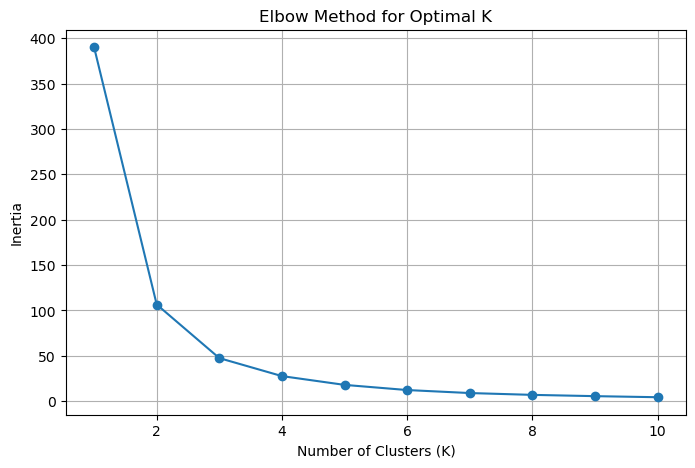

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method to find the optimal K
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data[['Week', 'Confirmed']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [34]:
# Optimal K (determine this from the Elbow Method)
optimal_k = 3  # Replace with the chosen K

# Fit K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(clustering_data[['Week', 'Confirmed']])

# Add cluster centers for visualization
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


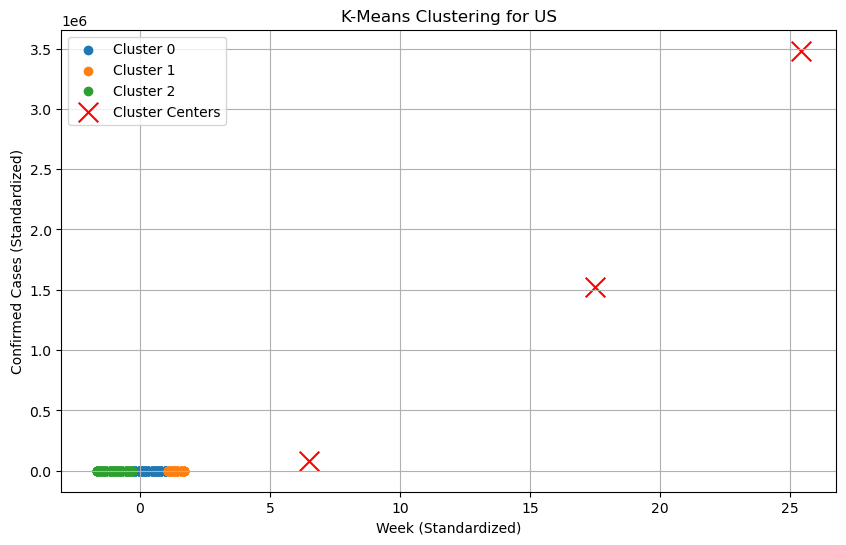

In [ ]:
# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_points = clustering_data[clustering_data['Cluster'] == cluster]
    plt.scatter(cluster_points['Week'], cluster_points['Confirmed'], label=f'Cluster {cluster}')

# Plot cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='x', s=200, label='Cluster Centers')

plt.title(f'K-Means Clustering for {selected_country}')
plt.xlabel('Week (Standardized)')
plt.ylabel('Confirmed Cases (Standardized)')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
# Get coordinates of the selected country
country_coords = df_melted[df_melted['Country/Region'] == selected_country][['Lat', 'Long']].mean()

# Calculate distance from the selected country
df_melted['Distance'] = ((df_melted['Lat'] - country_coords['Lat'])**2 + 
                        (df_melted['Long'] - country_coords['Long'])**2)**0.5

# Find neighboring countries based on distance
neighboring_countries = (df_melted.groupby('Country/Region')['Distance']
                       .mean()
                       .sort_values()
                       .head(4)
                       .index
                       .tolist())
neighboring_countries.remove(selected_country)
print(neighboring_countries)


['Mexico', 'Belize', 'Guatemala']


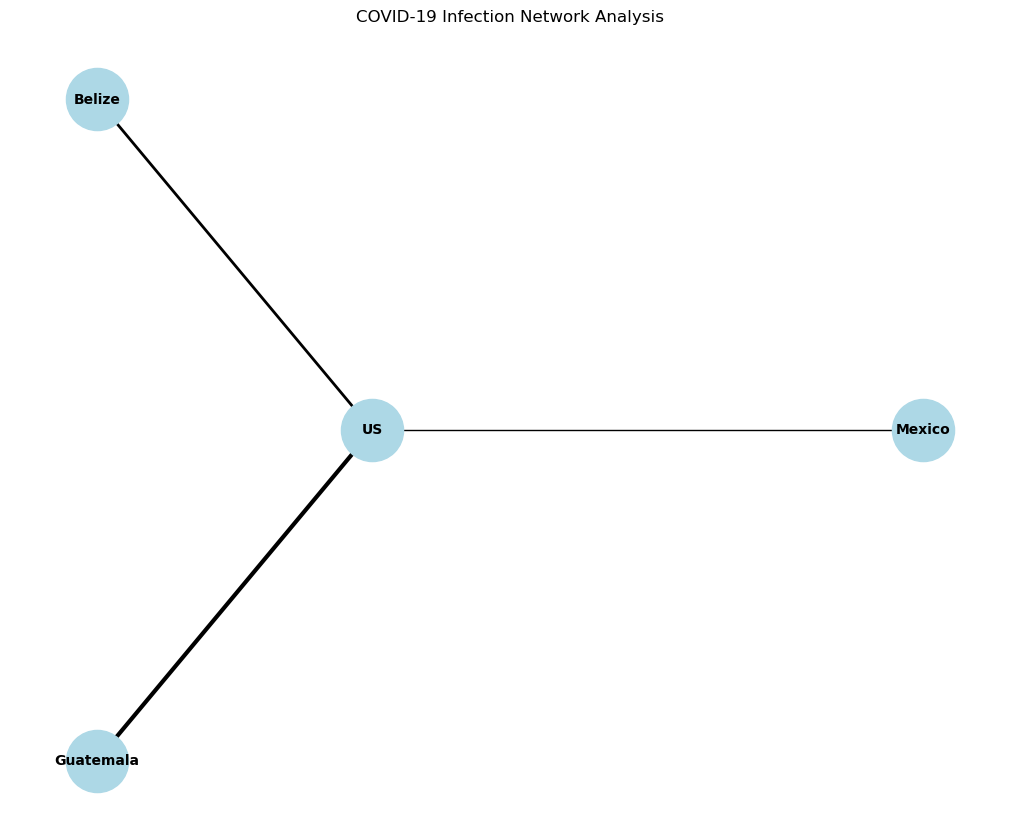

In [53]:
import networkx as nx
import numpy as np  # Make sure numpy is imported
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes and positions
G.add_node(selected_country, pos=(0, 0))  # Center node

for i, neighbor in enumerate(neighboring_countries):
    angle = 2 * np.pi * i / len(neighboring_countries)  # Arrange neighbors in a circular layout
    G.add_node(neighbor, pos=(np.cos(angle), np.sin(angle)))
    G.add_edge(selected_country, neighbor, weight=0.5 * (i + 1))  # Assign edge weights

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=2000,
    font_size=10,
    font_weight='bold',
    width=[G[u][v]['weight'] * 2 for u, v in G.edges()]
)
plt.title("COVID-19 Infection Network Analysis")
plt.show()

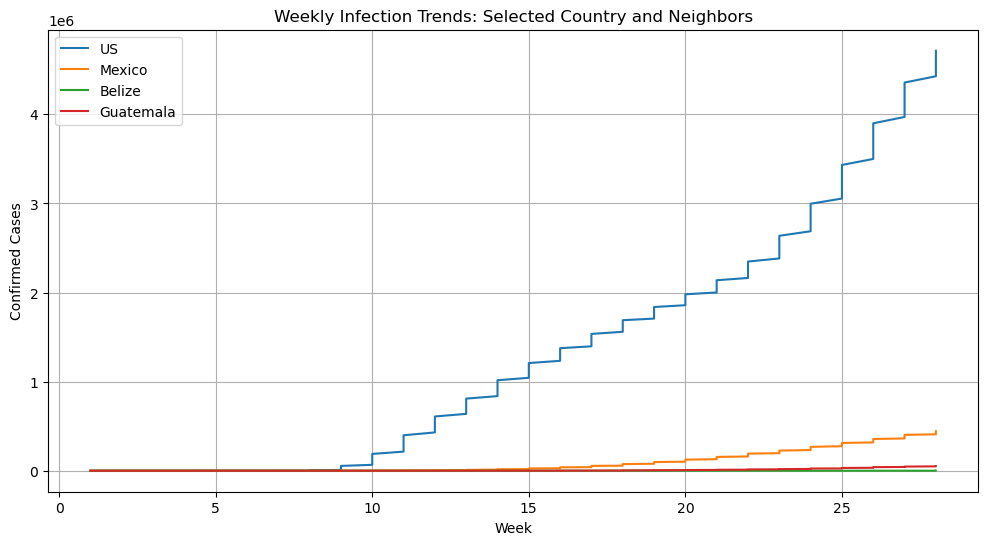

In [55]:
# Extract weekly infection data for the selected country
selected_country_data = df_grouped[df_grouped['Country/Region'] == selected_country]

# Extract weekly infection data for neighboring countries
neighbors_weekly_data = df_grouped[df_grouped['Country/Region'].isin(neighboring_countries)]

# Merge weekly infection data for all countries
merged_data = pd.concat([selected_country_data, neighbors_weekly_data])

# Plot weekly infection trends
plt.figure(figsize=(12, 6))
for country in [selected_country] + neighboring_countries:
    country_data = merged_data[merged_data['Country/Region'] == country]
    plt.plot(country_data['Week'], country_data['Confirmed'], label=country)

plt.title('Weekly Infection Trends: Selected Country and Neighbors')
plt.xlabel('Week')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# Add edge weights based on correlation between weekly infection counts
for neighbor in neighboring_countries:
    selected_country_series = merged_data[merged_data['Country/Region'] == selected_country].set_index('Week')['Confirmed']
    neighbor_series = merged_data[merged_data['Country/Region'] == neighbor].set_index('Week')['Confirmed']
    correlation = selected_country_series.corr(neighbor_series)
    G[selected_country][neighbor]['weight'] = correlation


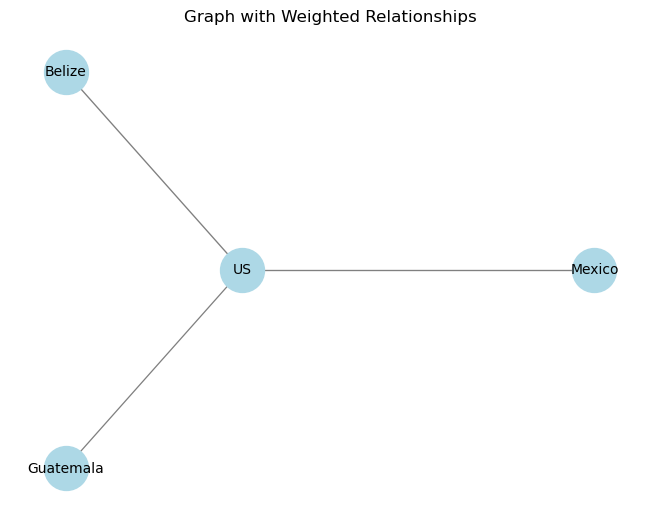

In [58]:
# Draw graph with weights
weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=10, edge_color='gray', width=list(weights))
plt.title('Graph with Weighted Relationships')
plt.show()
